In [ ]:
## %matplotlib inline

import numba
import numpy as np
import pandas as pd
import h5py
from gensim.models import word2vec
from rdkit import Chem
from mol2vec import features
from concurrent.futures import ThreadPoolExecutor
from matplotlib import pyplot as plt
from joblib import dump, load

# Building a Recommender

This notebook is the "final" step: using the embeddings, and building a machine learning pipeline that will recommend new molecules based on a set of molecules with known abundances. A large amount of the computation in this notebook is fairly intensive: starting with converting our 1.5 million molecules into embeddings, to training a model, and finally recommending molecules from a subset of the 1.5 million.

So to break down the steps:

1. Calculate `mol2vec` embeddings for our entire dataset of SMILES
2. Reduce the dimensionality of the embeddings, based on the full dataset
3. Pre-cluster similar molecules together with $K$-means clustering
4. Calculate column densities for new molecules within the TMC-1 clusters

In [2]:
# load the pretrained mol2vec model
m2v_model = word2vec.Word2Vec.load("mol2vec_model.pkl")

In [3]:
@numba.jit(fastmath=True)
def cosine_similarity(A, B):
    return np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))


@numba.jit(fastmath=True)
def pairwise_similarity(vectors):
    n = len(vectors)
    matrix = np.zeros((n, n), dtype=np.float32)
    for i in range(n):
        for j in range(n):
            matrix[i,j] = cosine_similarity(vectors[i], vectors[j])
    return matrix


def smi_to_vector(smi: str, model, radius=1):
    mol = Chem.MolFromSmiles(smi, sanitize=False)
    mol.UpdatePropertyCache(strict=False)
    Chem.GetSymmSSSR(mol)
    # generate a sentence from rdkit molecule
    sentence = features.mol2alt_sentence(mol, radius)
    # generate vector embedding from sentence and model
    vector = features.sentences2vec([sentence], model)
    return vector


def parallel_smi_vectorization(all_smiles, model, h5_ref, workers=4, vec_length=300):
    """
    This uses threading to perform the embedding and save it to the HDF5 dataset.
    Unfortunately, not appreciably faster :P
    """
    dataset = h5_ref.require_dataset("vectors", (len(all_smiles), vec_length), dtype=np.float32, chunks=(10000, 300))
    with ThreadPoolExecutor(workers) as pool:
        for index, result in enumerate(pool.map(
            smi_to_vector, all_smiles, (model for _ in range(len(all_smiles)))
        )):
            dataset[i,:] = result

            
def serial_smi_vectorization(all_smiles, model, h5_ref, vec_length=300):
    vectors = h5_ref.require_dataset("vectors", (len(all_smiles), vec_length), dtype=np.float32, chunks=(10000, vec_length))
    dt = h5py.string_dtype()
    smiles = h5_ref.create_dataset("smiles", (len(all_smiles),), dtype=dt)
    for index, result in enumerate(map(smi_to_vector, all_smiles, (model for _ in range(len(all_smiles))))):
        vectors[index,:] = result
        smiles[index] = all_smiles[index]

In [714]:
# load the TMC-1 data
df = pd.read_csv("../data/jacqueline_tmc1_more_combined.csv")
# remove the upper/lower limit strings
df["Column Density"] = df["Column Density "].str.replace(r">|<", "", regex=True).astype(float)

In [711]:
new_smi = list()
for smi in df["Notation"].to_list():
    mol = Chem.MolFromSmiles(smi, sanitize=False)
    new_smi.append(Chem.MolToSmiles(mol, canonical=True))

In [715]:
df["Sanitized"] = new_smi

# legacy code to ignore isotopologues
isotope_specs = ["13", "15", "34", "18"]
ignored = df.loc[~df["Notation"].str.contains("|".join(isotope_specs))].dropna(subset=["Column Density"])

# Generate vectors for all of the molecules in TMC
tmc_1_vecs = [smi_to_vector(smi, m2v_model)[0] for smi in ignored["Notation"].tolist()]

ignored["Vecs"] = tmc_1_vecs

# this arranges all the vectors into a 2D array where each row corresponds
# to a molecule, and the columns are features
tmc_1_vecs = np.vstack(tmc_1_vecs)

## Embedding generation for the whole dataset

This will run the RDKit to `mol2vec` pipeline on all the SMILES in the dataset. The `RERUN` flag lets you choose to skip this step.

In [6]:
RERUN = False

In [7]:
if RERUN:
    with open("collected_smiles.smi") as read_file:
        all_smiles = read_file.readlines()

    all_smiles = list(map(lambda x: x.strip(), all_smiles))
    
    h5_file = h5py.File("smiles_embeddings_300.h5", "a")
    serial_smi_vectorization(all_smiles, model, h5_file, 300)

else:
    # otherwise, load the precalculated embeddings
    h5_file = h5py.File("smiles_embeddings_300.h5", "a")

Because our dataset is so damn big, we have to do some pretty advanced computation to do our analysis. Here, we're using the `dask` package to do "lazy" computation: the point of this is that only a small part of data is held in memory at any given time, and is streamed as we do any sort of computation. The other advantage of using `dask` is that we can also do parallel computation, and with threading we can speed up our calculations.

In [8]:
from dask import array as da

from dask.distributed import Client, progress
client = Client(
    processes=False,
    threads_per_worker=4,
    n_workers=1,
    memory_limit='2GB')

client

Client Scheduler: inproc://172.16.23.145/3880704/1 Dashboard: http://172.16.23.145:8787/status,Cluster Workers: 1 Cores: 4 Memory: 2.00 GB


In [9]:
# Retrieve the vectors with prespecified chunk sizes
dask_vectors = da.from_array(h5_file["vectors"], chunks=(10000, 300))
smiles = np.asarray(h5_file["smiles"])

In [10]:
from dask_ml.decomposition import IncrementalPCA
from dask_ml.cluster import KMeans

## PCA of the full dataset

To get some insight into how efficiently our 300-features are being used, as well as reduce the dimensionality of our problem a little bit to help with the computational cost, we can use PCA. The issue, however, is that people will usually scream if you talk about doing PCA on a 1.5 million samples, 300-length feature dataset because it requires a lot of computational resources. In fact, we won't be able to do this on our laptops directly; instead, we're going to use an [`IncrementalPCA` algorithm](https://scikit-learn.org/stable/auto_examples/decomposition/plot_incremental_pca.html), which iteratively finds the principal components without needing to fit the entire dataset in memory. Functionally, this approximates the exact PCA, however may have slight differences due to "batching"; how many samples are used to determine principal components in each iteration.

In [11]:
pca_model = IncrementalPCA(n_components=None, batch_size=10000)

In [13]:
result = pca_model.fit(dask_vectors)

/home/kelvin/anaconda3/envs/rdkit/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


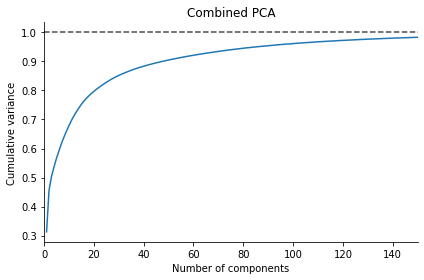

In [35]:
fig, ax = plt.subplots()

x = np.arange(1, result.explained_variance_ratio_.size + 1)

ax.plot(x, np.cumsum(result.explained_variance_ratio_))
ax.axhline(1., color="k", ls="--", alpha=0.7)
ax.set(xlabel="Number of components", ylabel="Cumulative variance", xlim=[0., 150.], title="Combined PCA")

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

fig.tight_layout()
fig.savefig("dataset_pca.png", dpi=300, transparent=True)

In [36]:
# Take the first 100 components
n_components = 100
pca_vectors = result.transform(dask_vectors)[:,:n_components]

## Clustering

With the PCA dimensions, we now want to perform clustering: a machine learning technique for associating things that are similar together (i.e. form clusters with data points). We will use our reduced dimensionality embeddings (now 100-elements) and compute how far each data point is from one another, and grouping them based on their distances. The most rudimentary method of doing this is with K-means clustering, and requires a specified number of expected clusters. In other applications, these clusters can have a physically significant or motivated basis: for example, certain molecules can be grouped together because they all contain nitrile groups, or some other feature about them. Since our embedding has mixed character in each dimension, it's hard to really interpret what these clusters actually represent, although we can try and infer their properties. Because this is all unsupervised, we do not need any use intuition to dictate _how these clusters are formed_.

The advantage of doing this clustering analysis is so that later on, when we want to recommend molecules we don't have ot run through the whole list: our K-means model will predict which cluster the molecule belongs in, and we only have to compute similarities within its cluster! This is much more computationally efficient, as we don't have to go through the full 1.5 million molecule everytime we want to predict something.

That said, training the $K$-means is actually the longest thing in this notebook!

In [37]:
kmeans_model = KMeans(n_clusters=10, random_state=42)

kmeans_result = kmeans_model.fit(pca_vectors)

In [38]:
# Associate ever ymolecule in our database to a cluster
cluster_ids = kmeans_result.labels_.compute()

In [41]:
try:
    del h5_file["cluster_ids"]
except:
    pass
# save the cluster ids to disk
h5_file["cluster_ids"] = cluster_ids

In [42]:
def dask_distance(A, B):
    return da.linalg.norm(A - B, axis=1)

In [66]:
tmc1_pca = pca_model.transform(tmc_1_vecs)[:,:n_components]

In [68]:
tmc1_clusters = kmeans_result.predict(tmc1_pca).compute()

With the exception of c-H2C3O, all the molecules in TMC-1 interestingly fall under cluster 9.

In [69]:
tmc1_clusters

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6], dtype=int32)

In [70]:
tmc1_distances = dask_distance(kmeans_result.cluster_centers_[-1], tmc1_pca)

In [71]:
ignored["distances"] = tmc1_distances

You can open the dataframe, and the `distances` column will show how far (in Euclidean distance) each molecule is from the last cluster centroid. While we don't have a good handle of what the clusters _actually correspond to_, by inspection of the molecules, it seems that this cluster very likely corresponds to small organic molecules.

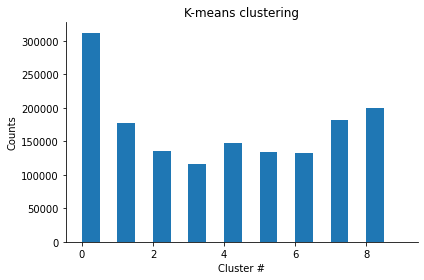

In [64]:
fig, ax = plt.subplots()

ax.hist(cluster_ids, bins=np.arange(10), width=0.5, lw=1.,)


for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

ax.set(xlabel="Cluster #", ylabel="Counts", title="K-means clustering")
fig.tight_layout()
fig.savefig("dataset_kmeans.png", dpi=300, transparent=True)

In [65]:
tmc1_kmeans = kmeans_result.transform(tmc1_pca).compute()

## Recommender System

We now have all the components to start "recommending molecules". Using the observed dataset of TMC-1 molecules, we're going to use a Gaussian process to perform regression, predicting the column density and its corresponding uncertainty.

In the following code, we're going to be doing a couple of wizardry things: machine learning models tend to "overfit" which is to say 

In [704]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels
from sklearn.model_selection import KFold

In [705]:
# This is K-fold validation; basically splits the data up randomly 10 different
# ways, and the point is to find the best, most general model
kf = KFold(10, random_state=42, shuffle=True)

In [536]:
X = tmc1_pca
Y = ignored["Column Density"].to_numpy()

The kernel we are going to be using is defined as:

$$ k = C \times \mathrm{RBF}(l_1) \times \sigma_0^2 + \mathrm{RBF}(l_2) $$

See [this link](https://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process) for definitions of each of the kernels.

In [639]:
# This is a poorly designed model; I manually fiddled around with the kernel definition and parameters
# until I got bored, and that the test sccore was reasonable
kernel = kernels.ConstantKernel(5., (1e-3, 1e5)) * kernels.RBF(2., (1e-2, 1e1)) * kernels.DotProduct(0.5, (1e-3, 1e1)) + kernels.RBF(3., (1e-3, 1e2))
gp_model = GaussianProcessRegressor(kernel, alpha=1e-3, normalize_y=True, random_state=42)

In [640]:
# This loop finds the most general model by selecting the highhest test score
best_dict = {"mean": 1e4, "test_score": 1e4}
for index, (train, test) in enumerate(kf.split(X, Y)):
    gp_result = gp_model.fit(X[train], Y[train])
    test_score = gp_result.score(X[test], Y[test])
    train_score = gp_result.score(X[train], Y[train])
    ll = gp_result.log_marginal_likelihood()
    if index == 0 or test_score >= best_dict["test_score"]:
        best_dict["model"] = gp_result
        best_dict["test_score"] = test_score
        best_dict["train_score"] = train_score
        best_dict["ll"] = ll
        best_dict["mean"] = np.mean([test_score, train_score])            

In [641]:
# log likelihood isn't as great as I'd like, but this is a very limited model!
best_dict

{'mean': 0.5014614473504374,
 'test_score': 0.31127827656165796,
 'model': GaussianProcessRegressor(alpha=0.001,
                          kernel=2.24**2 * RBF(length_scale=2) * DotProduct(sigma_0=0.5) + RBF(length_scale=3),
                          normalize_y=True, random_state=42),
 'train_score': 0.6916446181392168,
 'll': -7144.025143492071}

In [644]:
# find the index corresponding to the TMC-1 cluster group
tmc1_most_common_cluster = np.bincount(tmc1_clusters).argmax()

In [645]:
# Select out other molecules from the database that are also in this cluster
cluster_X = pca_vectors[cluster_ids == tmc1_most_common_cluster]

In [646]:
# Predict the abundance of molecules in the cluster, and their uncertainties
rec_N, rec_std = gp_result.predict(cluster_X, return_std=True)

In [670]:
# Return top 100 molecules
indices = rec_N.argsort()[::-1][:20]

In [749]:
# This first finds the SMILES corresponding to the TMC-1 cluster. We then select
# out the top 20 in column density from this cluster
proposed_smiles = smiles[cluster_ids == tmc1_most_common_cluster][indices]

In [756]:
# This picks out the molecules that are in our TMC-1 dataset to plot up against
actual = df.loc[df["Notation"].isin(proposed_smiles)]

In [746]:
select_x_grid = x_grid[np.isin(proposed_smiles, actual["Sanitized"].to_numpy())]

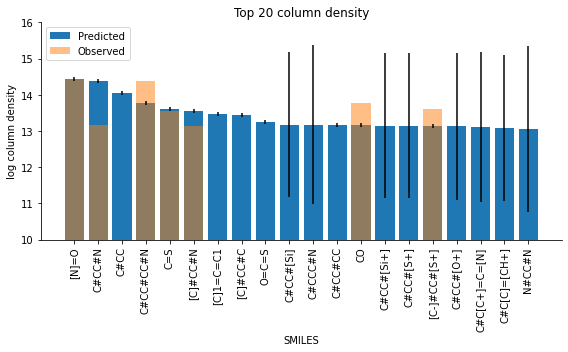

In [757]:
fig, ax = plt.subplots(figsize=(8, 5))

x_grid = np.arange(20)

ax.bar(
    np.arange(20),
    rec_N[indices],
    yerr=rec_std[indices],
    label="Predicted"
)

select_x_grid = x_grid[np.isin(proposed_smiles, actual["Notation"].to_numpy())]

ax.bar(
    select_x_grid,
    actual["Column Density"],
    alpha=0.5,
    label="Observed"
)

ax.set_xticks(x_grid)
ax.set_xticklabels(proposed_smiles, rotation=90.)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

ax.legend(loc=2)
ax.set(xlabel="SMILES", ylabel="log column density", ylim=[10., 16.], title="Top 20 column density")
    
fig.tight_layout()
fig.savefig("recommend_top20_N.png", dpi=300, transparent=True)

# Conclusions

This is a proof-of-concept to show that we can predict which molecules to look for by focusing on high column density and high uncertainty—the point isn't nececssarily to reproduce the column densities directly, but instead this tells us what we should focus on. An advantage of this framework is being able to update as we go: every new detection or upper limit can be included, and the predictions will hopefully improve as we update them. This is an advantage over chemical models, as adding new molecules does not necessarily improve its accuracy (you will always be missing out on stuff).

## Things that can be improved

The kernel used for the GP is likely to make a real statistician vomit. Ideally, we want the kernels to be designed with some physical basis, however this requires a better understanding of the `mol2vec` vectors. If we have a good kernel design, it's trivial to set up a grid search cross-validation experiment to tune the kernel hyperparameters, and give us the best statistical baseline possible.

Right now, some nonsensical molecules are being predicted despite having no elements in TMC-1: namely the silicon and phosphorus species. It is worth making these molecules uninformative priors with the column density around zero, so that the model doesn't necessarily predict them in high abundance (although also high uncertainty until we actually constrain them).

Finally, a GP isn't necessarily the optimal model. We can consider other types of models, however GPs are a good balance between performance, speed, and required dataset size. On the one hand, a deep neural network would be able to make good use of the `mol2vec` feature space, although our dataset is far too small to be able to train a network decently.